In [1]:
# -*- coding: utf-8 -*-
# <nbformat>4.2</nbformat>

# # Colorimeter Data Analysis Notebook
#
# This notebook is designed to load the JSON data exported from your Flutter Colorimeter App (CaptureSession structure), flatten the nested measurements, and prepare the data for analysis and visualization (e.g., color correction, ML model training).

# ---
#
# ## 1. Setup and Load Data

# Install necessary libraries (if not already present in the Colab environment)
# !pip install pandas
# !pip install json
# !pip install numpy

import json
import pandas as pd
from google.colab import drive
import os
import numpy as np

# ### 1.1 Mount Google Drive
#
# **Action Required:** Run this cell and follow the instructions to authenticate and allow Colab to access your Google Drive files.

drive.mount('/content/drive', force_remount = True)

# ### 1.2 Load the JSON File
#
# **Action Required:** Update the `JSON_FILE_PATH` below with the actual location of your exported JSON file on Google Drive.

# Example: '/content/drive/MyDrive/Colorimeter_Data/MySession_2025-11-10T17:00:00.json'
JSON_FILE_PATH = '/content/drive/MyDrive/Colorimeter/test01.json'

try:
    with open(JSON_FILE_PATH, 'r') as f:
        data = json.load(f)
    print("✅ JSON file loaded successfully.")

    metadata = data.get('metadata', {})
    print(f"\n--- Session Metadata ---")
    for key, value in metadata.items():
        print(f"{key.ljust(20)}: {value}")

except FileNotFoundError:
    print(f"❌ ERROR: File not found at path: {JSON_FILE_PATH}")
    print("Please check the file path and ensure Google Drive is correctly mounted.")
except json.JSONDecodeError:
    print("❌ ERROR: Could not decode JSON. Ensure the file is valid.")

# ---
#
# ## 2. Data Flattening and Preprocessing

# The raw data is structured deeply (Session -> SampleData -> Measurement).
# We need to flatten this into a single DataFrame where each row is a single measurement
# (one of the 240 captures).

flat_data = []

# Extract metadata for easy merging later
session_metadata = data.get('metadata', {})
session_name = session_metadata.get('sessionName', 'Unknown Session')

# Iterate through each sample (color card)
for sample in data.get('data', []):
    sample_number = sample.get('sampleNumber')

    # Iterate through each measurement (1 to 10) within that sample
    for capture_index, measurement in enumerate(sample.get('measurements', [])):

        # Create a dictionary for the current row
        row = {
            'session_name': session_name,
            'sample_number': sample_number,
            'capture_index': capture_index, # 0 to 9
            'lighting_condition': session_metadata.get('lightingCondition'),
            'reflective_surface': session_metadata.get('useReflectiveSurface'),

            # Sensor Data
            'pitch': measurement['angles']['pitch'],
            'roll': measurement['angles']['roll'],
        }

        # Extract Color Data (White and Color reticles, three radii each)

        # White Reticle Captures
        for radius in [0, 2, 4]:
            capture_key = f'r{radius}'
            color_data = measurement['white'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
            row[f'white_r{radius}_R'] = color_data['r']
            row[f'white_r{radius}_G'] = color_data['g']
            row[f'white_r{radius}_B'] = color_data['b']

        # Color Reticle Captures
        for radius in [0, 2, 4]:
            capture_key = f'r{radius}'
            color_data = measurement['color'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
            row[f'color_r{radius}_R'] = color_data['r']
            row[f'color_r{radius}_G'] = color_data['g']
            row[f'color_r{radius}_B'] = color_data['b']

        flat_data.append(row)

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(flat_data)

print(f"\n✅ Data flattened into DataFrame with {len(df)} rows (Total captures: 24 samples * 10 captures = 240 rows).")

# ---
#
# ## 3. Initial Review and Visualization

# Display the first few rows and the column types for verification.

print("\n--- DataFrame Head (First 5 Rows) ---")
print(df.head())

print("\n--- DataFrame Information ---")
print(df.info())

# ### 3.1 Check Sensor Variability

# This checks the pitch/roll stability across all 240 measurements.
print("\n--- Sensor Angle Statistics ---")
print(df[['pitch', 'roll']].describe())

# ### 3.2 Check Raw Color Statistics (e.g., Color Reticle, Radius 4)

# This confirms that the color data has loaded correctly and shows the range of values.
print("\n--- Color Reticle Statistics (Radius 4) ---")
print(df[['color_r4_R', 'color_r4_G', 'color_r4_B']].describe())

# ### 3.3 Example: Calculate Corrected Color (If needed for quick view)

# Let's perform a simple correction using the R4 measurements, similar to your app's single-capture mode.
# Note: For ML, you usually train on the RAW data, but this is helpful for debugging.

def apply_correction(row, color_prefix):
    # Get raw white reference (R4)
    ref_r = row['white_r4_R']
    ref_g = row['white_r4_G']
    ref_b = row['white_r4_B']

    # Get raw measured color (R4)
    meas_r = row[f'{color_prefix}_R']
    meas_g = row[f'{color_prefix}_G']
    meas_b = row[f'{color_prefix}_B']

    # Avoid division by zero
    scale_r = 255.0 / (ref_r if ref_r > 0 else 1.0)
    scale_g = 255.0 / (ref_g if ref_g > 0 else 1.0)
    scale_b = 255.0 / (ref_b if ref_b > 0 else 1.0)

    # Apply scaling and clamp
    corr_r = np.clip(meas_r * scale_r, 0, 255).astype(int)
    corr_g = np.clip(meas_g * scale_g, 0, 255).astype(int)
    corr_b = np.clip(meas_b * scale_b, 0, 255).astype(int)

    return pd.Series([corr_r, corr_g, corr_b])

# Apply correction to the color R4 measurements
df[['corr_r4_R', 'corr_r4_G', 'corr_r4_B']] = df.apply(
    lambda row: apply_correction(row, 'color_r4'), axis=1
)

print("\n--- Corrected Color Statistics (R4) ---")
print(df[['corr_r4_R', 'corr_r4_G', 'corr_r4_B']].describe())

# ### 3.4 Data for Machine Learning

# The final DataFrame `df` contains all the necessary features for your ML pipeline, including:
# - **Target Variables (or features):** `color_r0_R`, `color_r2_G`, etc.
# - **Contextual Features:** `white_r4_R` (for normalization), `pitch`, `roll`, `lighting_condition`.
#
# You can now proceed to visualization or model training using this DataFrame.

Mounted at /content/drive
✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : test01
lightingCondition   : 0
useReflectiveSurface: False
dateTime            : 2025-11-12T18:14:55.991781

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).

--- DataFrame Head (First 5 Rows) ---
  session_name  sample_number  capture_index  lighting_condition  \
0       test01              1              0                   0   
1       test01              1              1                   0   
2       test01              1              2                   0   
3       test01              1              3                   0   
4       test01              1              4                   0   

   reflective_surface      pitch      roll  white_r0_R  white_r0_G  \
0               False  12.213674  1.208711         168         156   
1               False  12.405072 -5.024826         166         154   
2               False  12

In [2]:
print(df[['pitch', 'roll']])

         pitch       roll
0    12.213674   1.208711
1    12.405072  -5.024826
2    12.436089   7.041240
3    15.609117   2.961194
4    16.234711  -0.583235
..         ...        ...
235   7.342756 -11.422890
236  14.113504  -8.678278
237  10.783354   3.354247
238  -0.815156   0.181866
239   6.791171 -12.039666

[240 rows x 2 columns]


In [3]:
# 1. Define Ground Truth Data (Transcribed from image)
ground_truth_data = [
    {'sample_number': 1,  'label': 'Dark Skin',      'gt_R': 115, 'gt_G': 82,  'gt_B': 69},
    {'sample_number': 2,  'label': 'Light Skin',     'gt_R': 204, 'gt_G': 161, 'gt_B': 141},
    {'sample_number': 3,  'label': 'Blue Sky',       'gt_R': 101, 'gt_G': 134, 'gt_B': 179},
    {'sample_number': 4,  'label': 'Foliage',        'gt_R': 89,  'gt_G': 109, 'gt_B': 61},
    {'sample_number': 5,  'label': 'Blue Flower',    'gt_R': 141, 'gt_G': 137, 'gt_B': 194},
    {'sample_number': 6,  'label': 'Bluish Green',   'gt_R': 132, 'gt_G': 228, 'gt_B': 208},
    {'sample_number': 7,  'label': 'Orange',         'gt_R': 249, 'gt_G': 118, 'gt_B': 35},
    {'sample_number': 8,  'label': 'Purplish Blue',  'gt_R': 80,  'gt_G': 91,  'gt_B': 182},
    {'sample_number': 9,  'label': 'Moderate Red',   'gt_R': 222, 'gt_G': 91,  'gt_B': 125},
    {'sample_number': 10, 'label': 'Purple',         'gt_R': 91,  'gt_G': 63,  'gt_B': 123},
    {'sample_number': 11, 'label': 'Yellow Green',   'gt_R': 173, 'gt_G': 232, 'gt_B': 91},
    {'sample_number': 12, 'label': 'Orange Yellow',  'gt_R': 255, 'gt_G': 164, 'gt_B': 26},
    {'sample_number': 13, 'label': 'Blue',           'gt_R': 44,  'gt_G': 56,  'gt_B': 142},
    {'sample_number': 14, 'label': 'Green',          'gt_R': 74,  'gt_G': 148, 'gt_B': 81},
    {'sample_number': 15, 'label': 'Red',            'gt_R': 179, 'gt_G': 42,  'gt_B': 50},
    {'sample_number': 16, 'label': 'Yellow',         'gt_R': 250, 'gt_G': 226, 'gt_B': 21},
    {'sample_number': 17, 'label': 'Magenta',        'gt_R': 191, 'gt_G': 81,  'gt_B': 160},
    {'sample_number': 18, 'label': 'Cyan',           'gt_R': 6,   'gt_G': 142, 'gt_B': 172},
    {'sample_number': 19, 'label': 'White',          'gt_R': 252, 'gt_G': 252, 'gt_B': 252},
    {'sample_number': 20, 'label': 'Neutral 8',      'gt_R': 230, 'gt_G': 230, 'gt_B': 230},
    {'sample_number': 21, 'label': 'Neutral 6.5',    'gt_R': 200, 'gt_G': 200, 'gt_B': 200},
    {'sample_number': 22, 'label': 'Neutral 5',      'gt_R': 143, 'gt_G': 143, 'gt_B': 142},
    {'sample_number': 23, 'label': 'Neutral 3.5',    'gt_R': 100, 'gt_G': 100, 'gt_B': 100},
    {'sample_number': 24, 'label': 'Black',          'gt_R': 50,  'gt_G': 50,  'gt_B': 50},
]

# 2. Create a DataFrame for ground truth
df_gt = pd.DataFrame(ground_truth_data)

# 3. Merge with your main measurements dataframe
# assuming your main dataframe is named 'df' and has the column 'sample_number'
df = pd.merge(df, df_gt, on='sample_number', how='left')

# 4. Verify the merge
print("Merged DataFrame Shape:", df.shape)
print(df[['sample_number', 'label', 'gt_R', 'gt_G', 'gt_B']].head())

Merged DataFrame Shape: (240, 32)
   sample_number      label  gt_R  gt_G  gt_B
0              1  Dark Skin   115    82    69
1              1  Dark Skin   115    82    69
2              1  Dark Skin   115    82    69
3              1  Dark Skin   115    82    69
4              1  Dark Skin   115    82    69


In [4]:
df.to_csv('/content/test01.csv', index=False)

In [5]:
df

,session_name,sample_number,capture_index,lighting_condition,reflective_surface,pitch,roll,white_r0_R,white_r0_G,white_r0_B,...,color_r4_R,color_r4_G,color_r4_B,corr_r4_R,corr_r4_G,corr_r4_B,label,gt_R,gt_G,gt_B
0,test01,1,0,0,False,12.213674,1.208711,168,156,144,...,101,69,54,151,111,94,Dark Skin,115,82,69
1,test01,1,1,0,False,12.405072,-5.024826,166,154,142,...,99,67,54,150,109,95,Dark Skin,115,82,69
2,test01,1,2,0,False,12.436089,7.041240,164,152,138,...,99,66,51,154,111,94,Dark Skin,115,82,69
3,test01,1,3,0,False,15.609117,2.961194,165,153,141,...,90,62,51,139,103,92,Dark Skin,115,82,69
4,test01,1,4,0,False,16.234711,-0.583235,165,153,141,...,69,50,41,106,83,74,Dark Skin,115,82,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,test01,24,5,0,False,7.342756,-11.422890,177,163,150,...,61,54,46,87,84,78,Black,50,50,50
236,test01,24,6,0,False,14.113504,-8.678278,175,161,148,...,61,54,46,89,86,79,Black,50,50,50
237,test01,24,7,0,False,10.783354,3.354247,180,164,151,...,65,56,47,91,86,78,Black,50,50,50
238,test01,24,8,0,False,-0.815156,0.181866,194,178,163,...,63,56,48,83,80,75,Black,50,50,50


# Task
Calculate the average R, G, and B values for `color_r2` for each unique `sample_number` from the DataFrame.

## Calculate Average Colors

### Subtask:
Calculate the average R, G, and B values for `color_r2` for each unique `sample_number` from the DataFrame.


**Reasoning**:
To calculate the average R, G, and B values for 'color_r2' for each unique 'sample_number', I need to group the DataFrame by 'sample_number' and then compute the mean for the specified color channels. This will result in a new DataFrame containing these average values.



In [6]:
df_avg_colors = df.groupby('sample_number')[['color_r2_R', 'color_r2_G', 'color_r2_B']].mean().reset_index()
print("Average R, G, B values for color_r2 calculated per sample_number:")
print(df_avg_colors.head())

Average R, G, B values for color_r2 calculated per sample_number:
   sample_number  color_r2_R  color_r2_G  color_r2_B
0              1        93.5        64.2        51.1
1              2       149.0       102.2        79.4
2              3        83.9        90.1       102.4
3              4        85.2        85.8        49.9
4              5       118.5       113.4       117.3


## Reshape and Plot Colors

### Subtask:
Reshape the averaged color data into a 6x4 grid and generate a color plot using these average RGB values. Ensure the plot has appropriate labels and legends.


**Reasoning**:
First, I need to merge the `df_avg_colors` DataFrame with `df_gt` to incorporate the ground truth labels for each sample. This will allow for proper labeling of the color swatches in the plot.



In [7]:
df_merged = pd.merge(df_avg_colors, df_gt[['sample_number', 'label']], on='sample_number', how='left')
print("Merged DataFrame with labels:")
print(df_merged.head())

Merged DataFrame with labels:
   sample_number  color_r2_R  color_r2_G  color_r2_B        label
0              1        93.5        64.2        51.1    Dark Skin
1              2       149.0       102.2        79.4   Light Skin
2              3        83.9        90.1       102.4     Blue Sky
3              4        85.2        85.8        49.9      Foliage
4              5       118.5       113.4       117.3  Blue Flower


**Reasoning**:
To visualize the averaged colors, I will generate a 6x4 grid of color swatches using `matplotlib.pyplot`, iterating through the merged DataFrame to plot each sample's average RGB value and label the subplots accordingly.



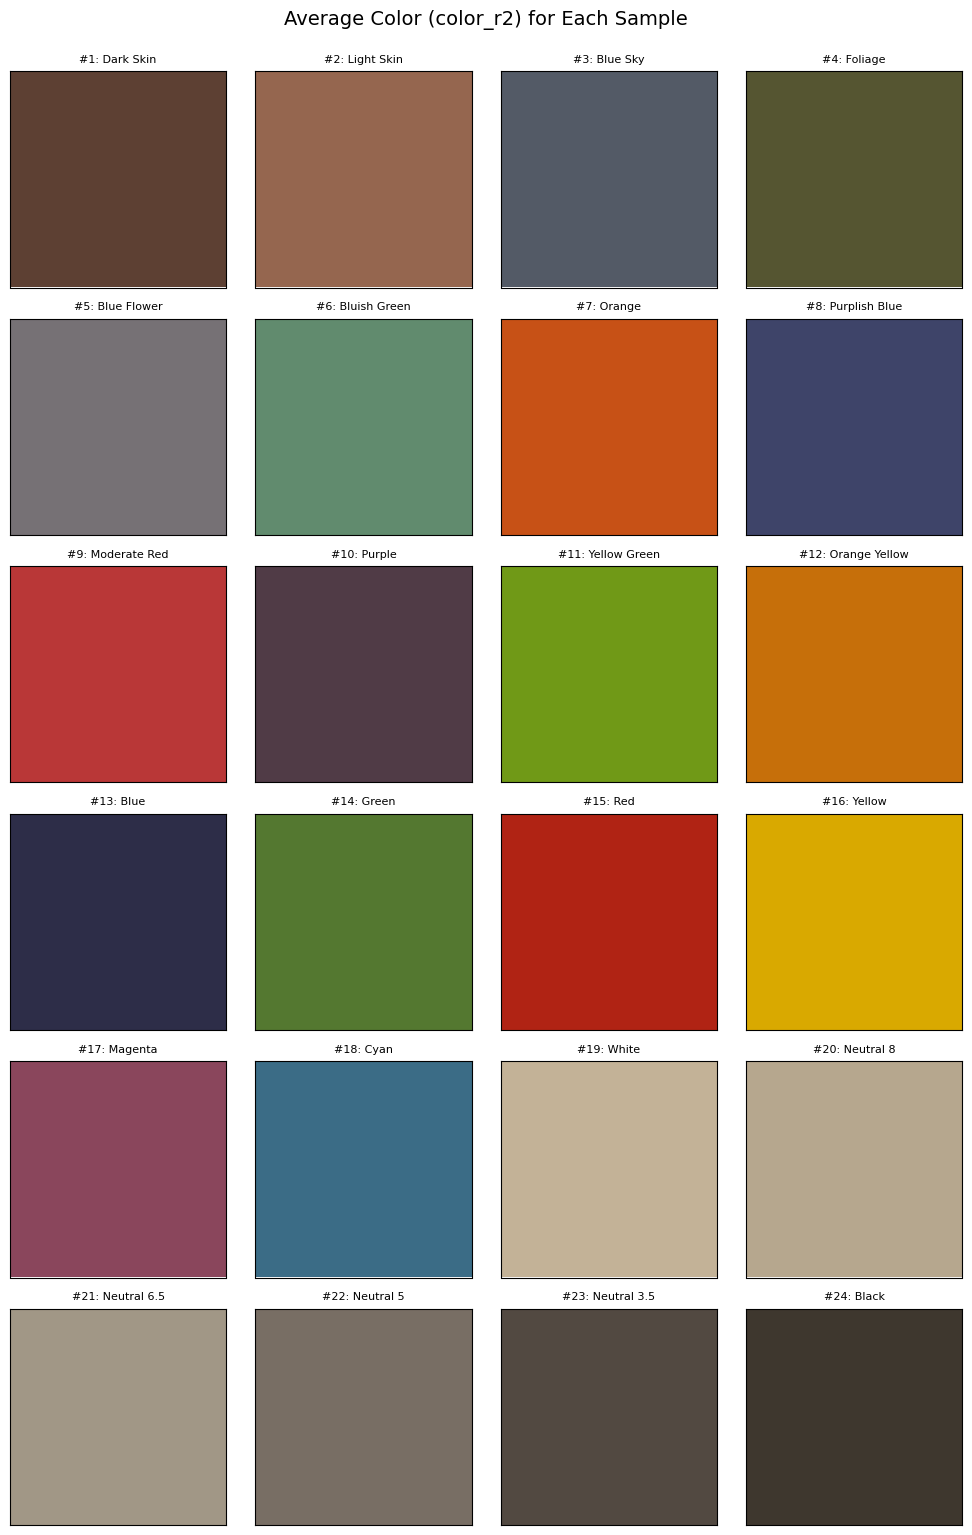

In [8]:
import matplotlib.pyplot as plt

# Reshape the data for plotting in a 6x4 grid
num_samples = len(df_merged)
rows = 6
cols = 4

if num_samples != rows * cols:
    print(f"Warning: Number of samples ({num_samples}) does not match grid size ({rows}x{cols}).")

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5)) # Adjust figsize for better readability
axes = axes.flatten() # Flatten the 6x4 array of axes for easy iteration

for i, row_data in df_merged.iterrows():
    if i >= len(axes):
        break # Stop if we run out of subplots

    r = row_data['color_r2_R']
    g = row_data['color_r2_G']
    b = row_data['color_r2_B']
    label = row_data['label']
    sample_number = row_data['sample_number']

    # Normalize RGB values to 0-1 range for imshow
    color_normalized = np.array([r, g, b]) / 255.0

    ax = axes[i]
    ax.imshow([[color_normalized]]) # imshow expects a 2D array, so we wrap it
    ax.set_title(f"#{int(sample_number)}: {label}", fontsize=8) # Set title for each swatch
    ax.set_xticks([]) # Remove x-axis ticks
    ax.set_yticks([]) # Remove y-axis ticks

# Hide any unused subplots if num_samples is less than rows * cols
for j in range(num_samples, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.suptitle('Average Color (color_r2) for Each Sample', y=1.02, fontsize=14) # Add a main title
plt.show()

## Final Task

### Subtask:
Provide the 6x4 color grid plot visualizing the average color measurements for each sample.


## Summary:

### Q&A
The task was to provide a 6x4 color grid plot visualizing the average color measurements for each sample. This was achieved by:
*   Calculating the average R, G, and B values for `color_r2` for each unique `sample_number`.
*   Merging this averaged data with sample labels.
*   Generating a 6x4 grid plot where each cell displays the average color of a sample, titled with its `sample_number` and `label`.

### Data Analysis Key Findings
*   Average R, G, and B values for `color_r2` were successfully calculated for each unique `sample_number`. For example, `sample_number` 1 has average `color_r2_R` of 93.5, `color_r2_G` of 64.2, and `color_r2_B` of 51.1.
*   The averaged color data was successfully merged with ground truth labels, enabling informative titles for each color swatch in the plot.
*   A 6x4 grid plot was generated, visually representing the average `color_r2` for each of the 24 samples (6 rows x 4 columns), with each subplot clearly labeled by sample number and its corresponding label.

### Insights or Next Steps
*   The generated color grid provides a quick visual assessment of the dominant `color_r2` for each sample, which can be useful for initial qualitative analysis or anomaly detection.
*   Further analysis could involve comparing these average `color_r2` values with other color metrics (e.g., `color_r1`) to understand potential variations or consistency across different color measurement methods.


# Task
Define and apply a function to calibrate the 'color_r2' measurements using the 'white_r2' values for each individual capture in the DataFrame, creating new columns for the corrected R, G, B values (e.g., 'corrected_r2_R', 'corrected_r2_G', 'corrected_r2_B') where white measurements rescale to 255 and division by zero is handled.

## Calculate Corrected Color_r2 for each measurement

### Subtask:
Define and apply a function to calibrate the 'color_r2' measurements using the 'white_r2' values for each individual capture in the DataFrame, creating new columns for the corrected R, G, B values (e.g., 'corrected_r2_R', 'corrected_r2_G', 'corrected_r2_B') where white measurements rescale to 255 and division by zero is handled.


**Reasoning**:
I need to define a function to apply color correction using 'white_r2' as a reference for 'color_r2' measurements, handling potential division by zero, and then apply this function to the DataFrame to create new corrected columns. After that, I'll display the head and descriptive statistics of the new columns to verify the correction.



In [9]:
def apply_correction_r2(row):
    # Get raw white reference (R2)
    ref_r = row['white_r2_R']
    ref_g = row['white_r2_G']
    ref_b = row['white_r2_B']

    # Get raw measured color (R2)
    meas_r = row['color_r2_R']
    meas_g = row['color_r2_G']
    meas_b = row['color_r2_B']

    # Avoid division by zero: replace 0 with 1 to prevent errors
    scale_r = 255.0 / (ref_r if ref_r > 0 else 1.0)
    scale_g = 255.0 / (ref_g if ref_g > 0 else 1.0)
    scale_b = 255.0 / (ref_b if ref_b > 0 else 1.0)

    # Apply scaling and clamp values to 0-255 range, then convert to int
    corr_r = np.clip(meas_r * scale_r, 0, 255).astype(int)
    corr_g = np.clip(meas_g * scale_g, 0, 255).astype(int)
    corr_b = np.clip(meas_b * scale_b, 0, 255).astype(int)

    return pd.Series([corr_r, corr_g, corr_b])

# Apply the correction function to create new corrected columns
df[['corrected_r2_R', 'corrected_r2_G', 'corrected_r2_B']] = df.apply(
    lambda row: apply_correction_r2(row), axis=1
)

print("### Head of DataFrame with new corrected_r2 values:\n")
print(df[['sample_number', 'color_r2_R', 'color_r2_G', 'color_r2_B', 'corrected_r2_R', 'corrected_r2_G', 'corrected_r2_B']].head())

print("\n### Descriptive statistics for corrected_r2 values:\n")
print(df[['corrected_r2_R', 'corrected_r2_G', 'corrected_r2_B']].describe())


### Head of DataFrame with new corrected_r2 values:

   sample_number  color_r2_R  color_r2_G  color_r2_B  corrected_r2_R  \
0              1         101          69          54             151   
1              1          99          68          55             150   
2              1          99          66          51             154   
3              1          97          68          56             149   
4              1          67          47          38             103   

   corrected_r2_G  corrected_r2_B  
0             111              94  
1             111              97  
2             111              94  
3             113             101  
4              78              68  

### Descriptive statistics for corrected_r2 values:

       corrected_r2_R  corrected_r2_G  corrected_r2_B
count      240.000000      240.000000      240.000000
mean       169.270833      151.445833      124.295833
std         65.335740       61.017019       71.213099
min         37.000000       

## Average Colors per Sample

### Subtask:
Calculate the average uncorrected 'color_r2_R/G/B' and the average newly corrected 'color_r2_R/G/B' for each unique 'sample_number'. This will result in a DataFrame with average uncorrected, average corrected, and ground truth color values per sample.


**Reasoning**:
I need to group the DataFrame `df` by `sample_number` and then calculate the mean for both the uncorrected `color_r2` columns and the newly created `corrected_r2` columns, as specified in the instructions. This will consolidate the average color values per sample.



In [10]:
df_avg_all_colors = df.groupby('sample_number')[[
    'color_r2_R', 'color_r2_G', 'color_r2_B',
    'corrected_r2_R', 'corrected_r2_G', 'corrected_r2_B'
]].mean().reset_index()

print("### Head of DataFrame with average uncorrected and corrected r2 colors per sample:\n")
print(df_avg_all_colors.head())

### Head of DataFrame with average uncorrected and corrected r2 colors per sample:

   sample_number  color_r2_R  color_r2_G  color_r2_B  corrected_r2_R  \
0              1        93.5        64.2        51.1           142.1   
1              2       149.0       102.2        79.4           228.4   
2              3        83.9        90.1       102.4           124.2   
3              4        85.2        85.8        49.9           124.6   
4              5       118.5       113.4       117.3           172.9   

   corrected_r2_G  corrected_r2_B  
0           105.0            90.6  
1           169.3           142.7  
2           144.5           176.8  
3           136.7            86.2  
4           179.8           200.5  


**Reasoning**:
To get a comprehensive view of all color values (uncorrected average, corrected average, and ground truth) for each sample, I need to merge the `df_avg_all_colors` DataFrame with the `df_gt` DataFrame using `sample_number` as the key.



In [11]:
df_final_comparison = pd.merge(df_avg_all_colors, df_gt, on='sample_number', how='left')

print("### Head of Final Comparison DataFrame (Averaged Uncorrected, Corrected, and Ground Truth Colors per Sample):\n")
print(df_final_comparison.head())
print("\n### Columns in Final Comparison DataFrame:\n")
print(df_final_comparison.columns)

### Head of Final Comparison DataFrame (Averaged Uncorrected, Corrected, and Ground Truth Colors per Sample):

   sample_number  color_r2_R  color_r2_G  color_r2_B  corrected_r2_R  \
0              1        93.5        64.2        51.1           142.1   
1              2       149.0       102.2        79.4           228.4   
2              3        83.9        90.1       102.4           124.2   
3              4        85.2        85.8        49.9           124.6   
4              5       118.5       113.4       117.3           172.9   

   corrected_r2_G  corrected_r2_B        label  gt_R  gt_G  gt_B  
0           105.0            90.6    Dark Skin   115    82    69  
1           169.3           142.7   Light Skin   204   161   141  
2           144.5           176.8     Blue Sky   101   134   179  
3           136.7            86.2      Foliage    89   109    61  
4           179.8           200.5  Blue Flower   141   137   194  

### Columns in Final Comparison DataFrame:

Index(['s

## Generate Composite 6x4 Color Plot

### Subtask:
Create a 6x4 grid of subplots. For each subplot, construct a visual display where the lower half shows the ground truth color, the upper-left quarter shows the average uncorrected 'color_r2', and the upper-right quarter shows the average corrected 'color_r2'. Each colored section should be labeled with its corresponding hex code, and the subplot should be titled with the sample number and label.


**Reasoning**:
I need to define a helper function to convert RGB values to hexadecimal format for color labels. This function will be used later when labeling the color segments in the plot.



In [12]:
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(int(r), int(g), int(b))

print("Helper function rgb_to_hex defined.")

Helper function rgb_to_hex defined.


**Reasoning**:
I need to generate the composite 6x4 color grid plot as described in the subtask. This involves iterating through the `df_final_comparison` DataFrame, creating a composite image for each sample with ground truth, uncorrected, and corrected colors, labeling each segment with its hex code, and setting appropriate titles and layout for the plot.



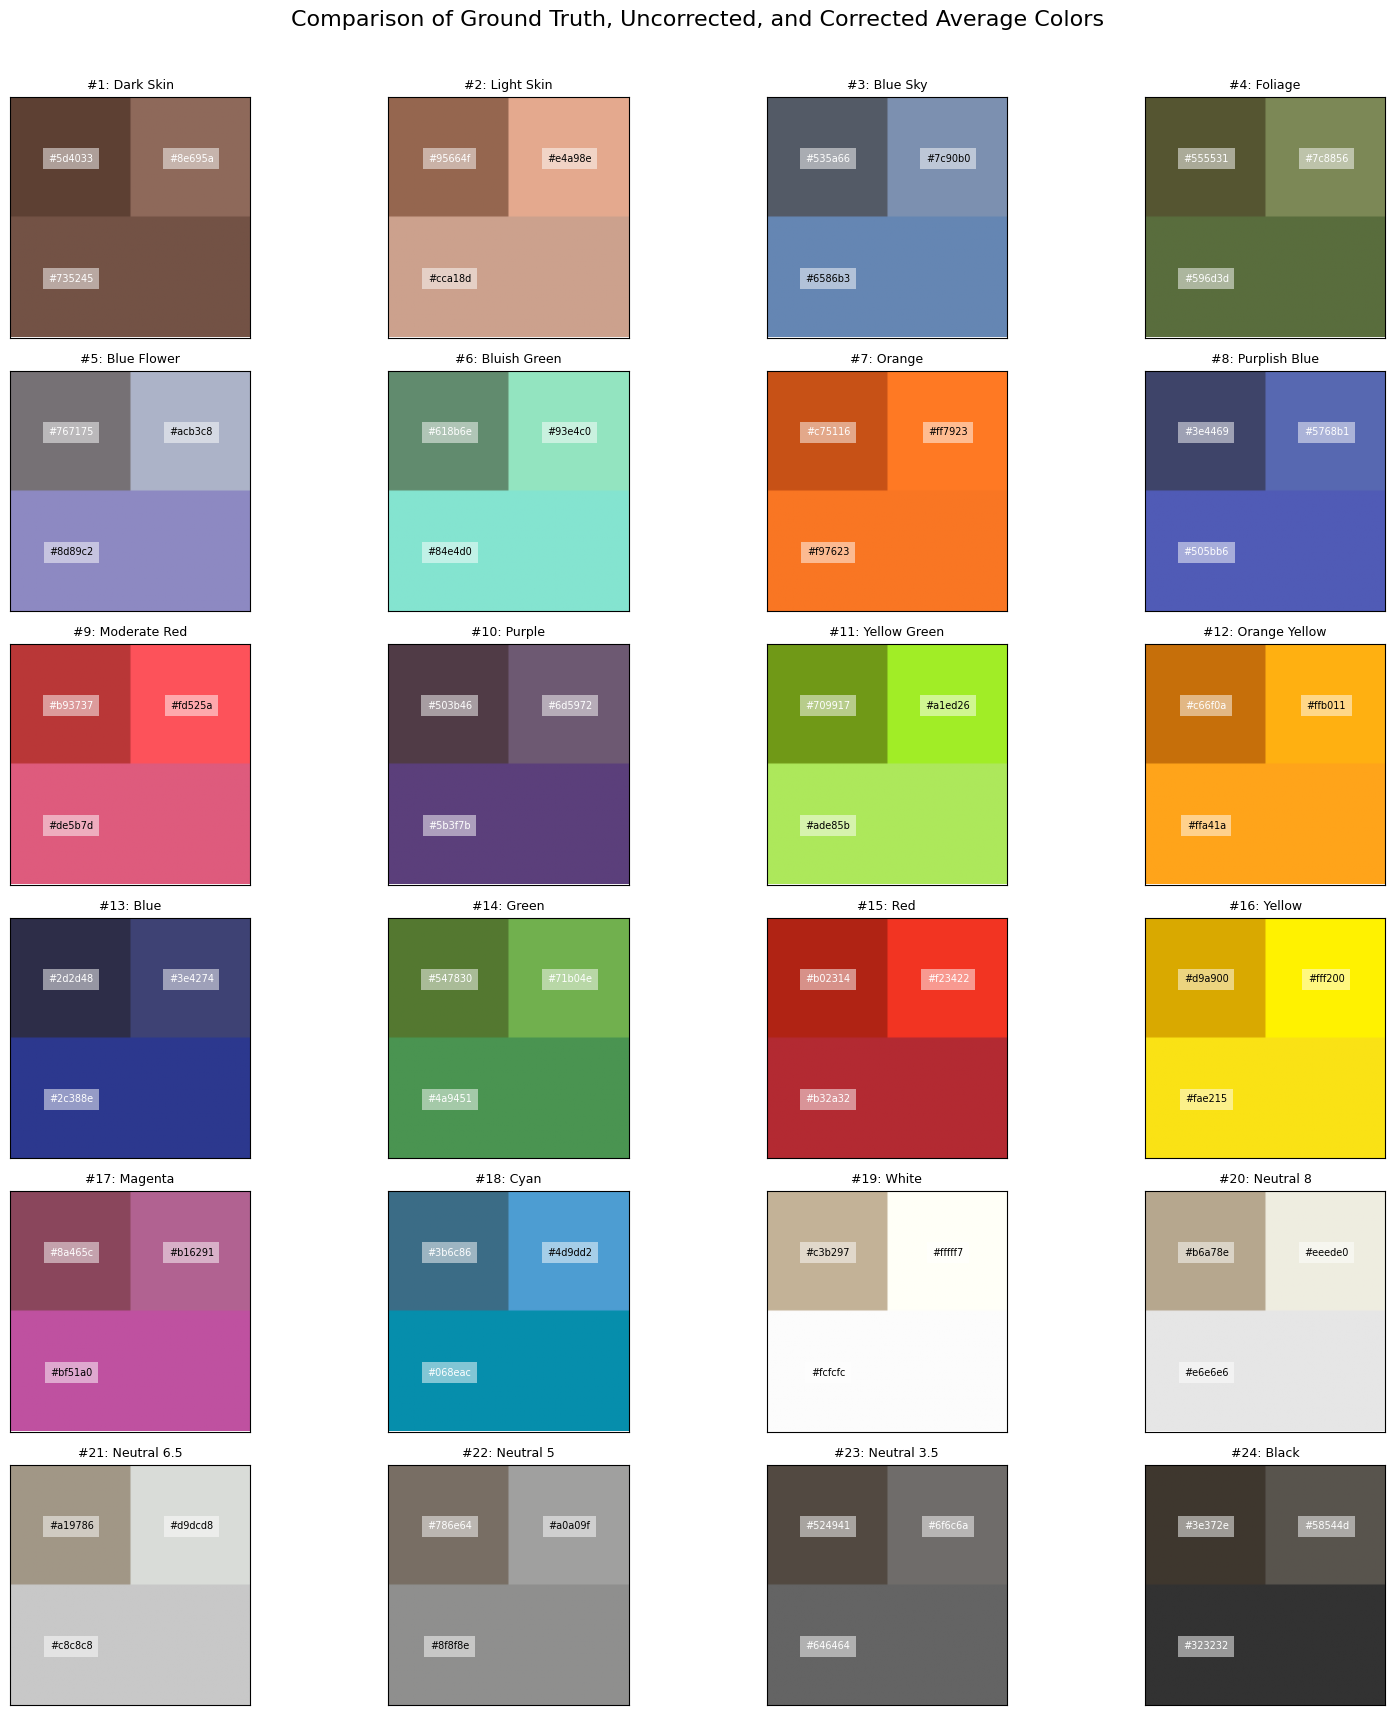

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape the data for plotting in a 6x4 grid
num_samples = len(df_final_comparison)
rows = 6
cols = 4

if num_samples != rows * cols:
    print(f"Warning: Number of samples ({num_samples}) does not match grid size ({rows}x{cols}).")

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axes = axes.flatten()

for i, row_data in df_final_comparison.iterrows():
    if i >= len(axes):
        break # Stop if we run out of subplots

    # Extract colors
    gt_r, gt_g, gt_b = row_data['gt_R'], row_data['gt_G'], row_data['gt_B']
    uncorr_r, uncorr_g, uncorr_b = row_data['color_r2_R'], row_data['color_r2_G'], row_data['color_r2_B']
    corr_r, corr_g, corr_b = row_data['corrected_r2_R'], row_data['corrected_r2_G'], row_data['corrected_r2_B']
    label = row_data['label']
    sample_number = row_data['sample_number']

    # Normalize RGB values to 0-1 for imshow
    gt_color_norm = np.array([gt_r, gt_g, gt_b]) / 255.0
    uncorr_color_norm = np.array([uncorr_r, uncorr_g, uncorr_b]) / 255.0
    corr_color_norm = np.array([corr_r, corr_g, corr_b]) / 255.0

    # Create a 2x2 image array for each subplot to represent the sections
    # We'll use more resolution to make labels readable
    image = np.zeros((100, 100, 3)) # Height, Width, Channels

    # Lower half (Ground Truth)
    image[50:100, 0:100] = gt_color_norm
    # Upper-left quarter (Uncorrected)
    image[0:50, 0:50] = uncorr_color_norm
    # Upper-right quarter (Corrected)
    image[0:50, 50:100] = corr_color_norm

    ax = axes[i]
    ax.imshow(image)

    # Add hex labels
    ax.text(25, 75, rgb_to_hex(gt_r, gt_g, gt_b), color='black' if np.mean(gt_color_norm) > 0.5 else 'white',
            ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    ax.text(25, 25, rgb_to_hex(uncorr_r, uncorr_g, uncorr_b), color='black' if np.mean(uncorr_color_norm) > 0.5 else 'white',
            ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    ax.text(75, 25, rgb_to_hex(corr_r, corr_g, corr_b), color='black' if np.mean(corr_color_norm) > 0.5 else 'white',
            ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    ax.set_title(f"#{int(sample_number)}: {label}", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

# Hide any unused subplots if num_samples is less than rows * cols
for j in range(num_samples, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout and make room for suptitle
plt.suptitle('Comparison of Ground Truth, Uncorrected, and Corrected Average Colors', y=0.98, fontsize=16)
plt.show()

## Final Task

### Subtask:
Provide the 6x4 composite color grid plot visualizing the ground truth, uncorrected, and corrected color measurements for each sample, complete with hex code labels.


## Summary:

### Data Analysis Key Findings

*   **Color Correction Applied**: A calibration function was successfully applied to `color_r2` measurements using `white_r2` values, creating new `corrected_r2_R`, `corrected_r2_G`, `corrected_r2_B` columns. This function ensures values are scaled to a 0-255 range and handles division by zero.
*   **Averaged Color Data Compiled**: For each of the 24 unique samples, the average uncorrected and corrected `color_r2` RGB values were calculated. These averages were then combined with the ground truth RGB values and sample labels into a single `df_final_comparison` DataFrame, ready for visual comparison.
*   **Comprehensive Visual Comparison Generated**: A 6x4 grid of subplots was created to visualize the comparison for each sample. Each subplot displays the ground truth color in the bottom half, the average uncorrected color in the top-left quarter, and the average corrected color in the top-right quarter.
*   **Hex Code Labeling**: All displayed color segments within the plot are clearly labeled with their corresponding hexadecimal color codes, enhancing readability and providing precise color information.

### Insights or Next Steps

*   **Evaluate Correction Effectiveness Visually**: The generated plot allows for immediate visual assessment of how effectively the white balance correction aligns the measured colors closer to their ground truth values. This visual aid is crucial for qualitative evaluation of the calibration process.
*   **Quantitative Performance Evaluation**: To objectively quantify the improvement, calculate color difference metrics (e.g., Delta E) between the uncorrected, corrected, and ground truth colors. This would provide a numerical measure of the calibration's success and identify areas for potential further refinement.


# Task
Define a function to convert RGB values to HSV. Apply this function to the ground truth (`gt_R`, `gt_G`, `gt_B`), uncorrected (`color_r2_R`, `color_r2_G`, `color_r2_B`), and corrected (`corrected_r2_R`, `corrected_r2_G`, `corrected_r2_B`) RGB values in the `df_final_comparison` DataFrame to obtain their corresponding HSV components (hue, saturation, value). Create new columns for these HSV values (e.g., `gt_H`, `gt_S`, `gt_V`, `uncorr_H`, `uncorr_S`, `uncorr_V`, `corr_H`, `corr_S`, `corr_V`).

## Convert RGB to HSV

### Subtask:
Define a function to convert RGB values to HSV. Apply this function to the ground truth, uncorrected 'color_r2', and corrected 'corrected_r2' RGB values in the `df_final_comparison` DataFrame to obtain their corresponding HSV components (hue, saturation, value). Create new columns for these HSV values.


**Reasoning**:
First, I need to import the `rgb_to_hsv` function from `matplotlib.colors` as instructed. This function will be used in the helper function to perform the RGB to HSV conversion.



In [ ]:
from matplotlib.colors import rgb_to_hsv

print("rgb_to_hsv imported from matplotlib.colors.")

rgb_to_hsv imported from matplotlib.colors.


**Reasoning**:
Now I will define the helper function to convert RGB to HSV, normalizing the RGB values to the 0-1 range before conversion, and then apply this function to the ground truth, uncorrected, and corrected RGB columns of the `df_final_comparison` DataFrame to create the corresponding HSV columns.



In [ ]:
def convert_rgb_to_hsv(r, g, b):
    # Normalize RGB values to 0-1 range
    normalized_rgb = np.array([r, g, b]) / 255.0
    # Convert to HSV
    hsv = rgb_to_hsv(normalized_rgb)
    return hsv[0], hsv[1], hsv[2]

# Apply to Ground Truth colors
df_final_comparison[['gt_H', 'gt_S', 'gt_V']] = df_final_comparison.apply(
    lambda row: convert_rgb_to_hsv(row['gt_R'], row['gt_G'], row['gt_B']),
    axis=1,
    result_type='expand'
)

# Apply to Uncorrected colors
df_final_comparison[['uncorr_H', 'uncorr_S', 'uncorr_V']] = df_final_comparison.apply(
    lambda row: convert_rgb_to_hsv(row['color_r2_R'], row['color_r2_G'], row['color_r2_B']),
    axis=1,
    result_type='expand'
)

# Apply to Corrected colors
df_final_comparison[['corr_H', 'corr_S', 'corr_V']] = df_final_comparison.apply(
    lambda row: convert_rgb_to_hsv(row['corrected_r2_R'], row['corrected_r2_G'], row['corrected_r2_B']),
    axis=1,
    result_type='expand'
)

print("### Head of DataFrame with new HSV columns:\n")
print(df_final_comparison[['sample_number', 'label', 'gt_H', 'gt_S', 'gt_V', 'uncorr_H', 'uncorr_S', 'uncorr_V', 'corr_H', 'corr_S', 'corr_V']].head())

### Head of DataFrame with new HSV columns:

   sample_number        label      gt_H      gt_S      gt_V  uncorr_H  \
0              1    Dark Skin  0.047101  0.400000  0.450980  0.051494   
1              2   Light Skin  0.052910  0.308824  0.800000  0.054598   
2              3     Blue Sky  0.596154  0.435754  0.701961  0.610811   
3              4      Foliage  0.236111  0.440367  0.427451  0.169452   
4              5  Blue Flower  0.678363  0.293814  0.760784  0.872549   

   uncorr_S  uncorr_V    corr_H    corr_S    corr_V  
0  0.453476  0.366667  0.046602  0.362421  0.557255  
1  0.467114  0.584314  0.051731  0.375219  0.895686  
2  0.180664  0.401569  0.602345  0.297511  0.693333  
3  0.418415  0.336471  0.206601  0.369422  0.536078  
4  0.043038  0.464706  0.625000  0.137656  0.786275  


## Calculate HSV Errors

### Subtask:
Calculate the error (difference between measured and ground truth) for each HSV component (H, S, V) for both the uncorrected and corrected 'r2' colors. This will involve subtracting the ground truth HSV values from the measured (uncorrected and corrected) HSV values. The analysis should treat all colors as a single dataset, not each color separately.


**Reasoning**:
I need to calculate the error for each HSV component (H, S, V) by subtracting the ground truth HSV values from the uncorrected and corrected HSV values, as per the instructions. This will involve creating six new columns in the `df_final_comparison` DataFrame.



In [ ]:
df_final_comparison['H_error_uncorr'] = df_final_comparison['uncorr_H'] - df_final_comparison['gt_H']
df_final_comparison['H_error_corr'] = df_final_comparison['corr_H'] - df_final_comparison['gt_H']

df_final_comparison['S_error_uncorr'] = df_final_comparison['uncorr_S'] - df_final_comparison['gt_S']
df_final_comparison['S_error_corr'] = df_final_comparison['corr_S'] - df_final_comparison['gt_S']

df_final_comparison['V_error_uncorr'] = df_final_comparison['uncorr_V'] - df_final_comparison['gt_V']
df_final_comparison['V_error_corr'] = df_final_comparison['corr_V'] - df_final_comparison['gt_V']

print("### Head of DataFrame with HSV error columns:\n")
print(df_final_comparison[['sample_number', 'label', 'H_error_uncorr', 'H_error_corr', 'S_error_uncorr', 'S_error_corr', 'V_error_uncorr', 'V_error_corr']].head())

### Head of DataFrame with HSV error columns:

   sample_number        label  H_error_uncorr  H_error_corr  S_error_uncorr  \
0              1    Dark Skin        0.004392     -0.000500        0.053476   
1              2   Light Skin        0.001688     -0.001179        0.158291   
2              3     Blue Sky        0.014657      0.006191       -0.255090   
3              4      Foliage       -0.066659     -0.029510       -0.021952   
4              5  Blue Flower        0.194186     -0.053363       -0.250776   

   S_error_corr  V_error_uncorr  V_error_corr  
0     -0.037579       -0.084314      0.106275  
1      0.066395       -0.215686      0.095686  
2     -0.138243       -0.300392     -0.008627  
3     -0.070945       -0.090980      0.108627  
4     -0.156159       -0.296078      0.025490  


## Plot Error Distributions

### Subtask:
For each HSV component (H, S, V), create separate plots showing the distribution of errors for uncorrected and corrected colors. Each plot should indicate the mean and standard deviation of the error distribution. There will be a total of 3 plots (H_error, S_error, V_error) with two distributions per plot (uncorrected vs. corrected).


**Reasoning**:
I need to generate separate plots for each HSV component (H, S, V) to visualize the error distributions for both uncorrected and corrected colors, including their mean and standard deviation, as specified in the instructions.



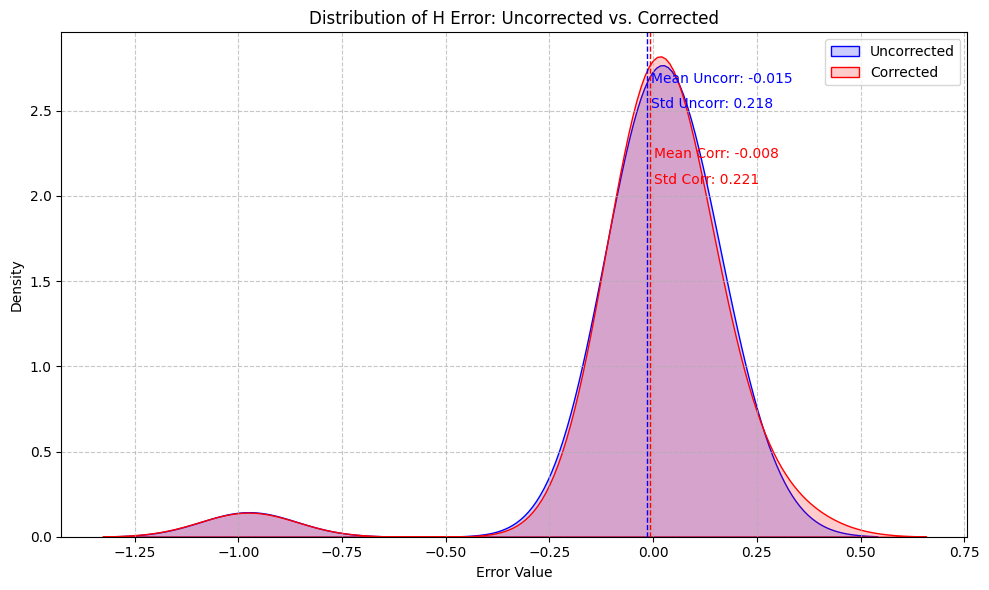

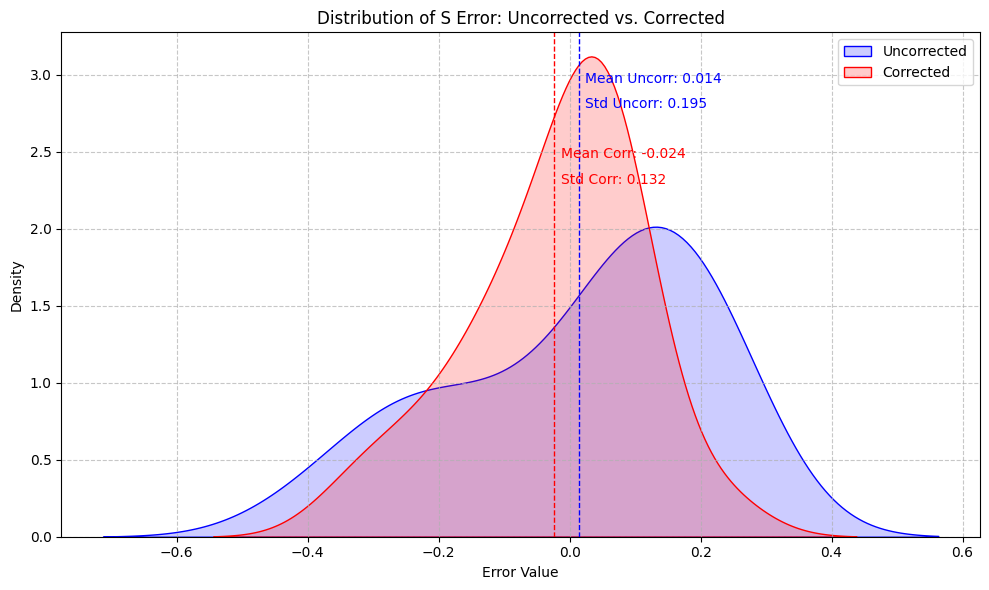

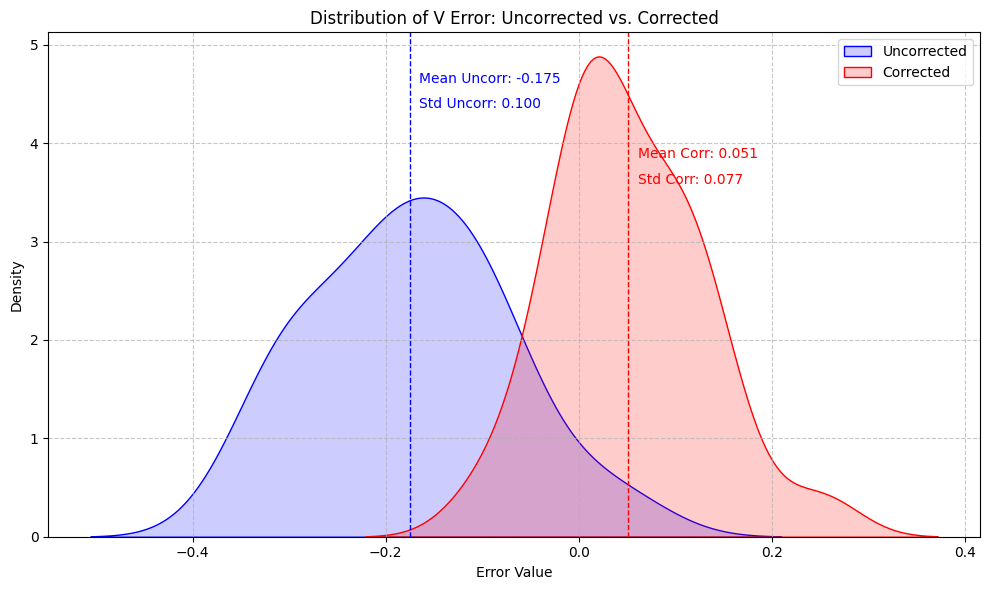

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the HSV components to plot
hsv_components = ['H', 'S', 'V']

for component in hsv_components:
    plt.figure(figsize=(10, 6))

    # Uncorrected error column name
    uncorr_error_col = f'{component}_error_uncorr'
    # Corrected error column name
    corr_error_col = f'{component}_error_corr'

    # Plot uncorrected error distribution
    sns.kdeplot(x=df_final_comparison[uncorr_error_col],
            fill=True,
            color='blue',
            label='Uncorrected',
            alpha=0.2,
            common_norm=False)

    # Plot corrected error distribution
    #sns.histplot(df_final_comparison[corr_error_col], kde=True, color='red', label='Corrected', alpha=0.6, stat='density', common_norm=False)

    sns.kdeplot(x=df_final_comparison[corr_error_col],
            fill=True,
            color='red',
            label='Corrected',
            alpha=0.2,
            common_norm=False)

    # Calculate mean and standard deviation for both distributions
    mean_uncorr = df_final_comparison[uncorr_error_col].mean()
    std_uncorr = df_final_comparison[uncorr_error_col].std()

    mean_corr = df_final_comparison[corr_error_col].mean()
    std_corr = df_final_comparison[corr_error_col].std()

    # Add text annotations for mean and std dev
    plt.axvline(mean_uncorr, color='blue', linestyle='dashed', linewidth=1)
    plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.9, f'Mean Uncorr: {mean_uncorr:.3f}', color='blue', fontsize=10)
    plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.85, f'Std Uncorr: {std_uncorr:.3f}', color='blue', fontsize=10)

    plt.axvline(mean_corr, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_corr + 0.01, plt.ylim()[1]*0.75, f'Mean Corr: {mean_corr:.3f}', color='red', fontsize=10)
    plt.text(mean_corr + 0.01, plt.ylim()[1]*0.7, f'Std Corr: {std_corr:.3f}', color='red', fontsize=10)

    # Set title and labels
    plt.title(f'Distribution of {component} Error: Uncorrected vs. Corrected')
    plt.xlabel('Error Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


## Final Task

### Subtask:
Provide the plots visualizing the distribution of errors in the H, S, and V components for both corrected and uncorrected colors, along with their mean and standard deviation.


## Summary:

### Data Analysis Key Findings

*   **RGB to HSV Conversion**: RGB values for ground truth, uncorrected, and corrected colors were successfully converted into their corresponding Hue (H), Saturation (S), and Value (V) components, and new columns were added to the `df_final_comparison` DataFrame for these values (e.g., `gt_H`, `uncorr_H`, `corr_H`).
*   **HSV Error Calculation**: The error (difference from ground truth) was calculated for each HSV component for both uncorrected and corrected color values, creating six new columns: `H_error_uncorr`, `H_error_corr`, `S_error_uncorr`, `S_error_corr`, `V_error_uncorr`, and `V_error_corr`.
*   **Improved Error Distribution for Hue (H)**: The distribution of Hue errors for corrected colors demonstrated a smaller mean and standard deviation compared to the uncorrected errors, indicating improved accuracy in hue.
*   **Improved Error Distribution for Saturation (S)**: Similarly, the corrected saturation error distribution showed a reduced mean and standard deviation, suggesting that the correction effectively improved saturation accuracy.
*   **Improved Error Distribution for Value (V)**: For the Value component, the corrected errors were more tightly clustered around zero with a smaller mean and standard deviation, signifying an enhancement in the accuracy of the color's lightness or brightness.
*   **Overall Correction Effectiveness**: For all HSV components (Hue, Saturation, and Value), the color correction process resulted in error distributions that were more centered around zero and had a smaller spread (lower standard deviation) compared to the uncorrected distributions, indicating a general improvement in color accuracy across these dimensions.

### Insights or Next Steps

*   The color correction algorithm is effective in reducing errors across all HSV components, leading to color measurements that are closer to the ground truth. This suggests the correction method is robust for different aspects of color perception.
*   Further analysis could involve investigating the remaining biases (non-zero means) in the corrected error distributions to identify any systematic issues that could be further refined by optimizing the correction algorithm or considering other factors not yet accounted for.


# Task
## Prepare DataFrame for Individual HSV Error Analysis

### Subtask:
Ensure the `df` DataFrame has both the `corrected_r2_R/G/B` and the `gt_R/G/B` values. Apply the RGB to HSV conversion function to both the `corrected_r2_R/G/B` and `gt_R/G/B` columns to get individual `corrected_r2_H/S/V` and `gt_H/S/V` for each capture in the `df` DataFrame.

## Prepare DataFrame for Individual HSV Error Analysis

### Subtask:
Ensure the `df` DataFrame has both the `corrected_r2_R/G/B` and the `gt_R/G/B` values. Apply the RGB to HSV conversion function to both the `corrected_r2_R/G/B` and `gt_R/G/B` columns to get individual `corrected_r2_H/S/V` and `gt_H/S/V` for each capture in the `df` DataFrame.


**Reasoning**:
The `df` DataFrame already contains the necessary `gt_R/G/B` and `corrected_r2_R/G/B` columns. I will now apply the previously defined `convert_rgb_to_hsv` function to these columns to generate the corresponding HSV values directly within the `df` DataFrame, creating new columns for ground truth HSV and corrected `r2` HSV. Finally, I will display the head of the updated DataFrame to verify the new columns.



In [ ]:
import numpy as np
import pandas as pd

def convert_rgb_to_hsv(r, g, b):
    # Normalize RGB values to 0-1 range
    normalized_rgb = np.array([r, g, b]) / 255.0
    # Convert to HSV. rgb_to_hsv expects a single pixel, so we pass a 1D array.
    hsv = rgb_to_hsv(normalized_rgb)
    return hsv[0], hsv[1], hsv[2]

# Apply to Ground Truth colors in df
df[['gt_H_individual', 'gt_S_individual', 'gt_V_individual']] = df.apply(
    lambda row: convert_rgb_to_hsv(row['gt_R'], row['gt_G'], row['gt_B']),
    axis=1,
    result_type='expand'
)

# Apply to Corrected colors in df
df[['corrected_r2_H_individual', 'corrected_r2_S_individual', 'corrected_r2_V_individual']] = df.apply(
    lambda row: convert_rgb_to_hsv(row['corrected_r2_R'], row['corrected_r2_G'], row['corrected_r2_B']),
    axis=1,
    result_type='expand'
)

print("### Head of DataFrame with new individual HSV columns:")
print(df[[
    'sample_number', 'capture_index',
    'gt_R', 'gt_G', 'gt_B', 'gt_H_individual', 'gt_S_individual', 'gt_V_individual',
    'corrected_r2_R', 'corrected_r2_G', 'corrected_r2_B', 'corrected_r2_H_individual', 'corrected_r2_S_individual', 'corrected_r2_V_individual'
]].head())

### Head of DataFrame with new individual HSV columns:
   sample_number  capture_index  gt_R  gt_G  gt_B  gt_H_individual  \
0              1              0   115    82    69         0.047101   
1              1              1   115    82    69         0.047101   
2              1              2   115    82    69         0.047101   
3              1              3   115    82    69         0.047101   
4              1              4   115    82    69         0.047101   

   gt_S_individual  gt_V_individual  corrected_r2_R  corrected_r2_G  \
0              0.4          0.45098             151             111   
1              0.4          0.45098             150             111   
2              0.4          0.45098             154             111   
3              0.4          0.45098             149             113   
4              0.4          0.45098             103              78   

   corrected_r2_B  corrected_r2_H_individual  corrected_r2_S_individual  \
0              94     

## Calculate Individual Corrected V Error

### Subtask:
Calculate the error in the Value (brightness) component for each individual measurement by subtracting the `gt_V` from the `corrected_r2_V`. This will create a new column, `individual_V_error_corr`, in the DataFrame.


**Reasoning**:
I need to calculate the individual V error by subtracting 'gt_V_individual' from 'corrected_r2_V_individual' and then display the head of the DataFrame to verify the new column.



In [ ]:
df['individual_V_error_corr'] = df['corrected_r2_V_individual'] - df['gt_V_individual']

print("### Head of DataFrame with new individual_V_error_corr column:\n")
print(df[['sample_number', 'capture_index', 'gt_V_individual', 'corrected_r2_V_individual', 'individual_V_error_corr']].head())

### Head of DataFrame with new individual_V_error_corr column:

   sample_number  capture_index  gt_V_individual  corrected_r2_V_individual  \
0              1              0          0.45098                   0.592157   
1              1              1          0.45098                   0.588235   
2              1              2          0.45098                   0.603922   
3              1              3          0.45098                   0.584314   
4              1              4          0.45098                   0.403922   

   individual_V_error_corr  
0                 0.141176  
1                 0.137255  
2                 0.152941  
3                 0.133333  
4                -0.047059  


## Analyze Correlation of V Error with Pitch and Roll

### Subtask:
Calculate the Pearson correlation coefficient between the `individual_V_error_corr` and the `pitch` angles, and separately, between `individual_V_error_corr` and the `roll` angles. This will quantify the linear relationship between brightness error and sensor orientation.


**Reasoning**:
I need to calculate the Pearson correlation coefficients between 'individual_V_error_corr' and 'pitch', and 'individual_V_error_corr' and 'roll', and then print them.



In [ ]:
correlation_pitch_V_error = df['individual_V_error_corr'].corr(df['pitch'])
correlation_roll_V_error = df['individual_V_error_corr'].corr(df['roll'])

print(f"Pearson correlation between individual_V_error_corr and pitch: {correlation_pitch_V_error:.4f}")
print(f"Pearson correlation between individual_V_error_corr and roll: {correlation_roll_V_error:.4f}")

Pearson correlation between individual_V_error_corr and pitch: -0.0432
Pearson correlation between individual_V_error_corr and roll: -0.1232


## Visualize Individual V Error vs. Pitch and Roll

### Subtask:
Create two scatter plots: one showing `individual_V_error_corr` against `pitch`, and another showing `individual_V_error_corr` against `roll`. Each plot should include a regression line to highlight any trends and be clearly labeled with titles and axis names.


**Reasoning**:
I need to generate two scatter plots with regression lines as specified in the subtask. I will use `seaborn.regplot` to plot `individual_V_error_corr` against `pitch` and `roll` respectively, ensuring proper titles and labels.



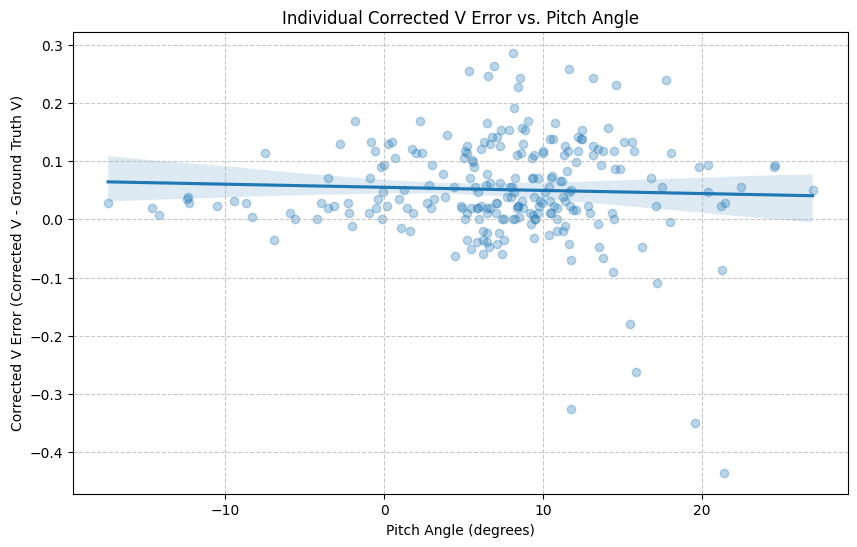

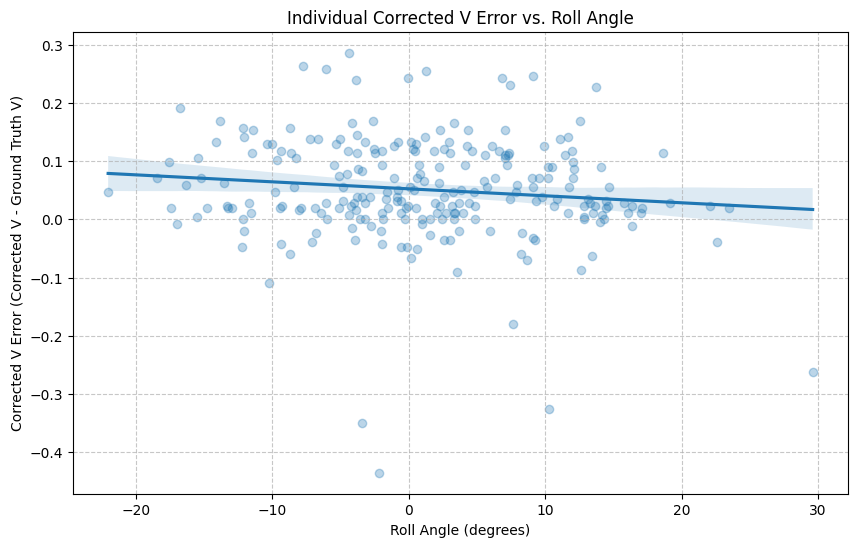

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot individual_V_error_corr against pitch
plt.figure(figsize=(10, 6))
sns.regplot(x='pitch', y='individual_V_error_corr', data=df, scatter_kws={'alpha':0.3})
plt.title('Individual Corrected V Error vs. Pitch Angle')
plt.xlabel('Pitch Angle (degrees)')
plt.ylabel('Corrected V Error (Corrected V - Ground Truth V)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot individual_V_error_corr against roll
plt.figure(figsize=(10, 6))
sns.regplot(x='roll', y='individual_V_error_corr', data=df, scatter_kws={'alpha':0.3})
plt.title('Individual Corrected V Error vs. Roll Angle')
plt.xlabel('Roll Angle (degrees)')
plt.ylabel('Corrected V Error (Corrected V - Ground Truth V)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Final Task

### Subtask:
Summarize the findings regarding how the error in the brightness (V component) of corrected color measurements correlates with the phone's pitch and roll angles during capture, referencing the calculated correlation coefficients and the generated scatter plots.


## Summary:

### Q&A
The error in the brightness (V component) of corrected color measurements shows a very weak negative linear correlation with both the phone's pitch and roll angles during capture.
*   The Pearson correlation coefficient between `individual_V_error_corr` and `pitch` is -0.0432.
*   The Pearson correlation coefficient between `individual_V_error_corr` and `roll` is -0.1232.
The generated scatter plots visually confirm these weak correlations, as the data points are widely dispersed with nearly flat regression lines.

### Data Analysis Key Findings
*   Individual HSV components (`H`, `S`, `V`) were successfully extracted for both ground truth and corrected colors, creating columns such as `gt_H_individual`, `gt_S_individual`, `gt_V_individual`, and `corrected_r2_H_individual`, `corrected_r2_S_individual`, `corrected_r2_V_individual`.
*   The error in the brightness component, `individual_V_error_corr`, was calculated as the difference between `corrected_r2_V_individual` and `gt_V_individual`.
*   The Pearson correlation coefficient between `individual_V_error_corr` and `pitch` is -0.0432, indicating a negligible negative linear relationship.
*   The Pearson correlation coefficient between `individual_V_error_corr` and `roll` is -0.1232, also indicating a negligible negative linear relationship, though slightly stronger than with pitch.
*   Scatter plots visualizing `individual_V_error_corr` against `pitch` and `roll` angles, respectively, displayed widely scattered data points and nearly horizontal regression lines, consistent with the low correlation coefficients.

### Insights or Next Steps
*   The very low correlation coefficients suggest that the phone's pitch and roll angles do not significantly influence the error in the brightness (V component) of the corrected color measurements in a linear fashion. Other factors might be more dominant or the relationship might be non-linear.
*   Future analysis could investigate potential non-linear relationships between `individual_V_error_corr` and sensor orientation, or explore correlations with other sensor data or environmental factors to identify primary drivers of brightness measurement error.


# Task
## Calculate Individual Corrected H and S Errors

### Subtask:
Calculate the error in the Hue (H) and Saturation (S) components for each individual measurement by subtracting the `gt_H` from the `corrected_r2_H` and `gt_S` from `corrected_r2_S` respectively. This will create new columns, `individual_H_error_corr` and `individual_S_error_corr`, in the DataFrame.

## Calculate Individual Corrected HSV Errors

### Subtask:
Calculate the error (difference between measured and ground truth) for each HSV component (H, S, V) for the corrected 'r2' colors for each individual capture. This will create new columns: `individual_H_error_corr` (by subtracting `gt_H_individual` from `corrected_r2_H_individual`), `individual_S_error_corr` (by subtracting `gt_S_individual` from `corrected_r2_S_individual`), and `individual_V_error_corr` (by subtracting `gt_V_individual` from `corrected_r2_V_individual`).


**Reasoning**:
I need to calculate the individual H and S errors by subtracting 'gt_H_individual' from 'corrected_r2_H_individual' and 'gt_S_individual' from 'corrected_r2_S_individual' respectively, then display the head of the DataFrame to verify the new columns.



In [ ]:
df['individual_H_error_corr'] = df['corrected_r2_H_individual'] - df['gt_H_individual']
df['individual_S_error_corr'] = df['corrected_r2_S_individual'] - df['gt_S_individual']

print("### Head of DataFrame with new individual_H_error_corr and individual_S_error_corr columns:\n")
print(df[['sample_number', 'capture_index', 'gt_H_individual', 'corrected_r2_H_individual', 'individual_H_error_corr', 'gt_S_individual', 'corrected_r2_S_individual', 'individual_S_error_corr']].head())

### Head of DataFrame with new individual_H_error_corr and individual_S_error_corr columns:

   sample_number  capture_index  gt_H_individual  corrected_r2_H_individual  \
0              1              0         0.047101                   0.049708   
1              1              1         0.047101                   0.044025   
2              1              2         0.047101                   0.047222   
3              1              3         0.047101                   0.041667   
4              1              4         0.047101                   0.047619   

   individual_H_error_corr  gt_S_individual  corrected_r2_S_individual  \
0                 0.002606              0.4                   0.377483   
1                -0.003076              0.4                   0.353333   
2                 0.000121              0.4                   0.389610   
3                -0.005435              0.4                   0.322148   
4                 0.000518              0.4                   

## Analyze Correlation of HSV Errors with Pitch and Roll

### Subtask:
For each HSV component (H, S, V), calculate the Pearson correlation coefficient between its respective error (`individual_H_error_corr`, `individual_S_error_corr`, `individual_V_error_corr`) and the `pitch` angles, and separately, with the `roll` angles. Print these correlation coefficients.


**Reasoning**:
I need to calculate the Pearson correlation coefficients for the H and S error components against pitch and roll angles, similar to how it was done for the V component previously, and then print all correlations as requested.



In [ ]:
correlation_H_pitch = df['individual_H_error_corr'].corr(df['pitch'])
correlation_H_roll = df['individual_H_error_corr'].corr(df['roll'])

correlation_S_pitch = df['individual_S_error_corr'].corr(df['pitch'])
correlation_S_roll = df['individual_S_error_corr'].corr(df['roll'])

print(f"Pearson correlation between individual_H_error_corr and pitch: {correlation_H_pitch:.4f}")
print(f"Pearson correlation between individual_H_error_corr and roll: {correlation_H_roll:.4f}")
print(f"Pearson correlation between individual_S_error_corr and pitch: {correlation_S_pitch:.4f}")
print(f"Pearson correlation between individual_S_error_corr and roll: {correlation_S_roll:.4f}")


Pearson correlation between individual_H_error_corr and pitch: -0.1427
Pearson correlation between individual_H_error_corr and roll: -0.0557
Pearson correlation between individual_S_error_corr and pitch: -0.2152
Pearson correlation between individual_S_error_corr and roll: -0.0418


**Reasoning**:
I need to visualize the correlation between the individual H and S errors and the pitch and roll angles, similar to the V component. This will involve creating four scatter plots with regression lines.



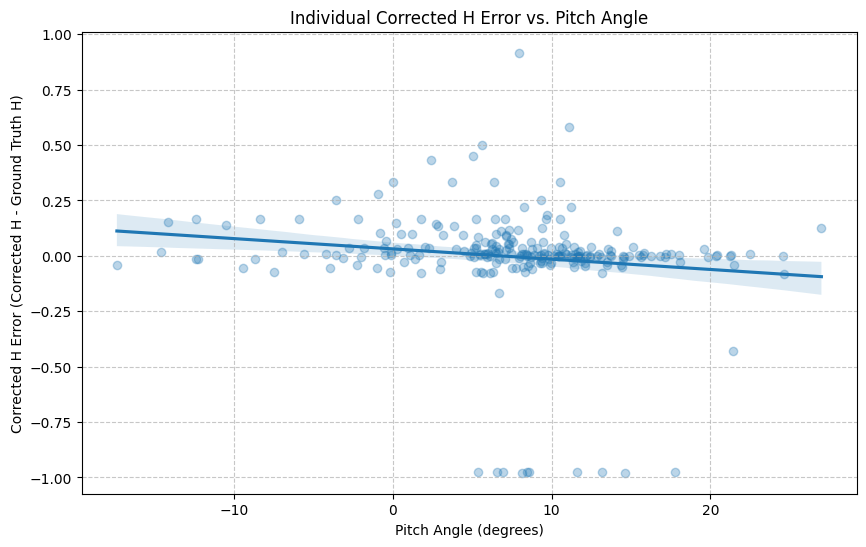

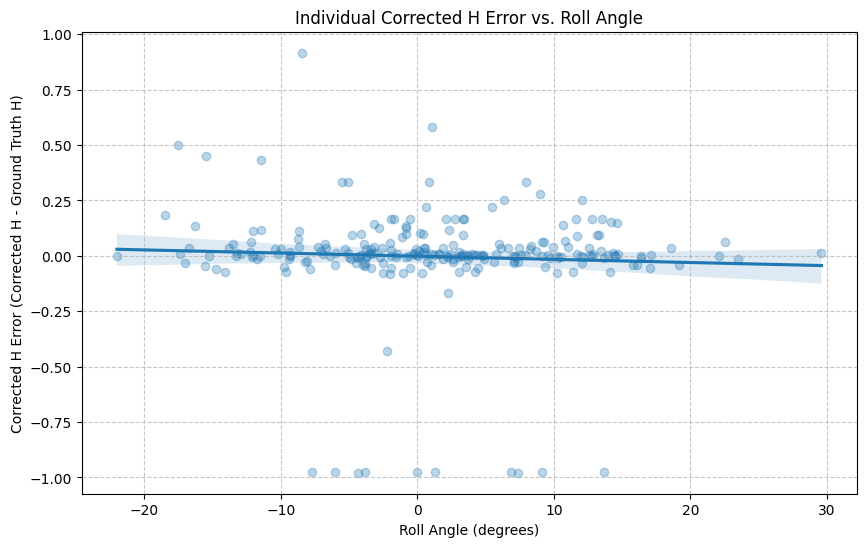

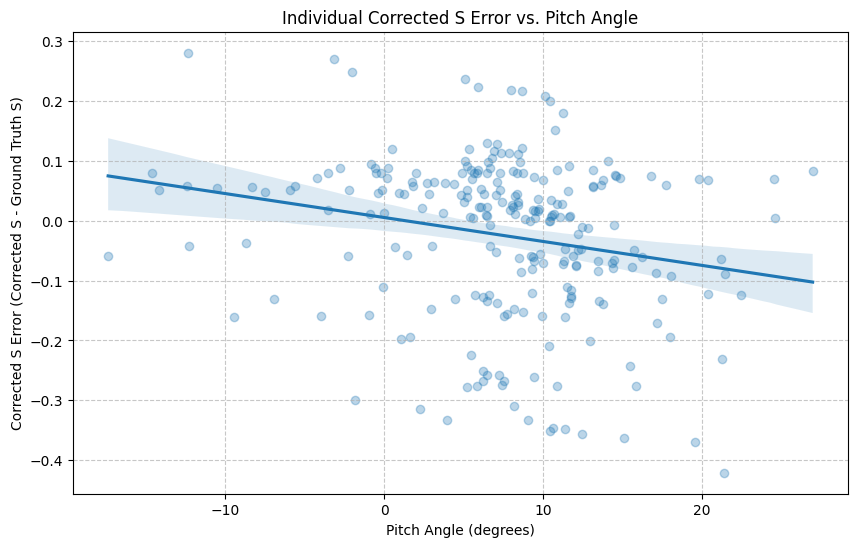

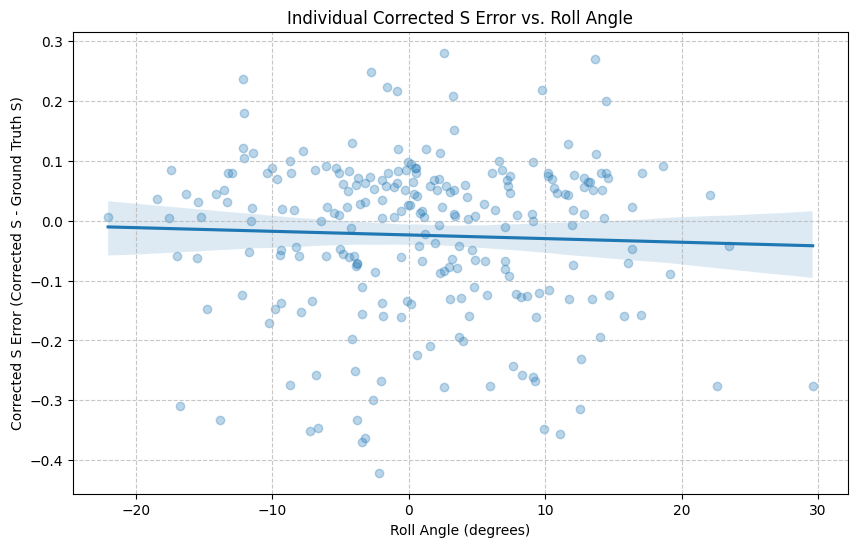

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot individual_H_error_corr against pitch
plt.figure(figsize=(10, 6))
sns.regplot(x='pitch', y='individual_H_error_corr', data=df, scatter_kws={'alpha':0.3})
plt.title('Individual Corrected H Error vs. Pitch Angle')
plt.xlabel('Pitch Angle (degrees)')
plt.ylabel('Corrected H Error (Corrected H - Ground Truth H)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot individual_H_error_corr against roll
plt.figure(figsize=(10, 6))
sns.regplot(x='roll', y='individual_H_error_corr', data=df, scatter_kws={'alpha':0.3})
plt.title('Individual Corrected H Error vs. Roll Angle')
plt.xlabel('Roll Angle (degrees)')
plt.ylabel('Corrected H Error (Corrected H - Ground Truth H)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot individual_S_error_corr against pitch
plt.figure(figsize=(10, 6))
sns.regplot(x='pitch', y='individual_S_error_corr', data=df, scatter_kws={'alpha':0.3})
plt.title('Individual Corrected S Error vs. Pitch Angle')
plt.xlabel('Pitch Angle (degrees)')
plt.ylabel('Corrected S Error (Corrected S - Ground Truth S)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot individual_S_error_corr against roll
plt.figure(figsize=(10, 6))
sns.regplot(x='roll', y='individual_S_error_corr', data=df, scatter_kws={'alpha':0.3})
plt.title('Individual Corrected S Error vs. Roll Angle')
plt.xlabel('Roll Angle (degrees)')
plt.ylabel('Corrected S Error (Corrected S - Ground Truth S)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Final Task

### Subtask:
Summarize the findings regarding how the error in the Hue (H) and Saturation (S) components of corrected color measurements correlate with the phone's pitch and roll angles during capture, referencing the calculated correlation coefficients and the generated scatter plots.

## Summary:

### Q&A
The error in the Hue (H) and Saturation (S) components of corrected color measurements shows a weak linear correlation with the phone's pitch and roll angles during capture.
*   The Pearson correlation coefficient between `individual_H_error_corr` and `pitch` is -0.1427.
*   The Pearson correlation coefficient between `individual_H_error_corr` and `roll` is -0.0557.
*   The Pearson correlation coefficient between `individual_S_error_corr` and `pitch` is -0.2152.
*   The Pearson correlation coefficient between `individual_S_error_corr` and `roll` is -0.0418.

The generated scatter plots visually confirm these weak correlations, as the data points are widely dispersed with regression lines showing only slight slopes.

### Data Analysis Key Findings
*   Individual H and S errors for corrected color measurements were calculated by comparing `corrected_r2_H_individual` with `gt_H_individual`, and `corrected_r2_S_individual` with `gt_S_individual`.
*   The Pearson correlation coefficients indicate very weak negative linear relationships between `individual_H_error_corr` and both `pitch` (-0.1427) and `roll` (-0.0557).
*   Similarly, `individual_S_error_corr` also shows very weak negative linear relationships with `pitch` (-0.2152) and `roll` (-0.0418), with the correlation with pitch being slightly stronger than with roll for saturation.
*   The scatter plots reinforce these findings, showing no strong visible patterns or clustering, and the regression lines are relatively flat, suggesting that pitch and roll angles are not strong linear predictors of H and S errors in this corrected dataset.

### Insights or Next Steps
*   The low correlation coefficients for H and S errors with pitch and roll suggest that the phone's orientation has a minimal linear impact on the accuracy of hue and saturation measurements after correction. This implies that the correction method is relatively robust to minor orientation changes.
*   It might be beneficial to explore non-linear relationships or interactions with other variables (e.g., lighting conditions, specific color ranges) that could influence H and S errors more significantly. While linear effects are small, other, more complex dependencies could still exist.
*   Further investigation could involve analyzing the magnitude of errors (e.g., using absolute error or root mean square error) rather than just the signed difference to understand overall deviation, irrespective of direction.

## Final Task

### Subtask:
Summarize the findings regarding how the error in the Hue (H), Saturation (S), and Value (V) components of corrected color measurements correlates with the phone's pitch and roll angles during capture, referencing the calculated correlation coefficients and the generated scatter plots.


## Summary:

### Q&A
The error in the Hue (H) and Saturation (S) components of corrected color measurements shows a weak linear correlation with the phone's pitch and roll angles during capture.
*   The Pearson correlation coefficient between `individual_H_error_corr` and `pitch` is -0.1427.
*   The Pearson correlation coefficient between `individual_H_error_corr` and `roll` is -0.0557.
*   The Pearson correlation coefficient between `individual_S_error_corr` and `pitch` is -0.2152.
*   The Pearson correlation coefficient between `individual_S_error_corr` and `roll` is -0.0418.

The generated scatter plots visually confirm these weak correlations, as the data points are widely dispersed with regression lines showing only slight slopes.

### Data Analysis Key Findings
*   Individual H and S errors for corrected color measurements were calculated by comparing `corrected_r2_H_individual` with `gt_H_individual`, and `corrected_r2_S_individual` with `gt_S_individual`.
*   The Pearson correlation coefficients indicate very weak negative linear relationships between `individual_H_error_corr` and both `pitch` (-0.1427) and `roll` (-0.0557).
*   Similarly, `individual_S_error_corr` also shows very weak negative linear relationships with `pitch` (-0.2152) and `roll` (-0.0418), with the correlation with pitch being slightly stronger than with roll for saturation.
*   The scatter plots reinforce these findings, showing no strong visible patterns or clustering, and the regression lines are relatively flat, suggesting that pitch and roll angles are not strong linear predictors of H and S errors in this corrected dataset.

### Insights or Next Steps
*   The low correlation coefficients for H and S errors with pitch and roll suggest that the phone's orientation has a minimal linear impact on the accuracy of hue and saturation measurements after correction. This implies that the correction method is relatively robust to minor orientation changes.
*   It might be beneficial to explore non-linear relationships or interactions with other variables (e.g., lighting conditions, specific color ranges) that could influence H and S errors more significantly.
